In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.listdir("../data")

['sample_submission.csv', 'test.csv', 'train.csv']

In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [4]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

 #TabNetRegressor()
#clf.fit(
#  X_train, Y_train,
#  eval_set=[(X_valid, y_valid)]
#)
#preds = clf.predict(X_test)

In [5]:
xcolumns = list(test.columns)
ycolumns = "NSP"

In [6]:
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

class Gini(Metric):
    def __init__(self):
        self._name = "gini"
        self._maximize = True

    def __call__(self, y_true, y_score):
        #print(y_true, np.argmax(y_score, 1))
        n_size = np.max(y_true)+1
        y_true_ = np.eye(n_size)[y_true]
        auc = roc_auc_score(y_true_, y_score, average='macro', multi_class="ovr")
        return max(2*auc - 1, 0.)

class F1(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True
        
    def __call__(self, y_true, y_score):
        return f1_score(y_true, np.argmax(y_score, 1), average='weighted')

In [7]:
#!pip install histbook
#!pip install vega
import seaborn as sns
#!pip install --upgrade seaborn
sns.__version__

'0.11.0'

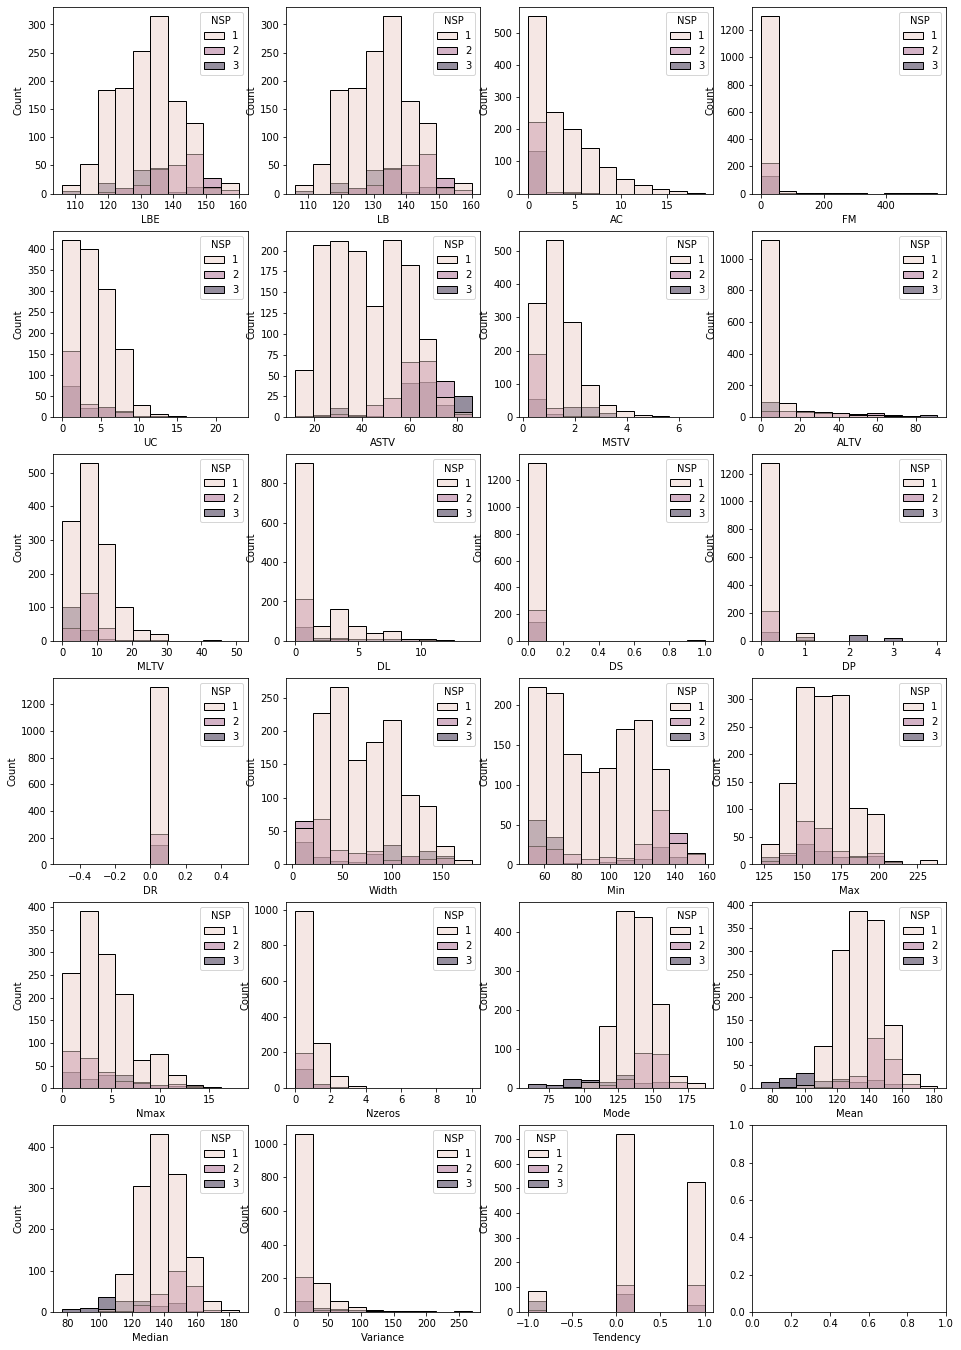

In [8]:
fig, axes = plt.subplots(ncols=4, nrows=6, figsize=(16, 6*4))

for col, ax in zip(xcolumns, axes.flatten()):
    sns.histplot(train, x=col, hue=ycolumns, ax=ax, bins=10)
    #train[col].hist(bins=10, ax=ax)
    #ax.set_title(col)
    

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, QuantileTransformer, KBinsDiscretizer

ct = ColumnTransformer(
    #[("norm1", Normalizer(norm='l1'), ["LBE"]),
    [
        #(
        #    'quant', QuantileTransformer(n_quantiles=400, output_distribution='normal'),
        #    ["LBE"]
        #),
        (
            "quant", KBinsDiscretizer(n_bins=100, encode="ordinal", strategy="uniform"),#QuantileTransformer(n_quantiles=100, output_distribution='normal'),#"passthrough",
            [
                'LBE',
                'LB',
                'AC',
                'FM',
                'UC',
                'ASTV',
                'MSTV',
                'ALTV',
                'MLTV',
                'DL',
                'DS',
                'DP',
                'DR',
                'Width',
                'Min',
                'Max',
                'Nmax',
                'Nzeros',
                'Mode',
                'Mean',
                'Median',
                'Variance',
                'Tendency'
            ]
        )

     #("norm2", Normalizer(norm='l1'), slice(2, 4))
    ])

/Users/lacemaker/anaconda3/envs/data_env/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant and will be replaced with 0.
  "replaced with 0." % jj)


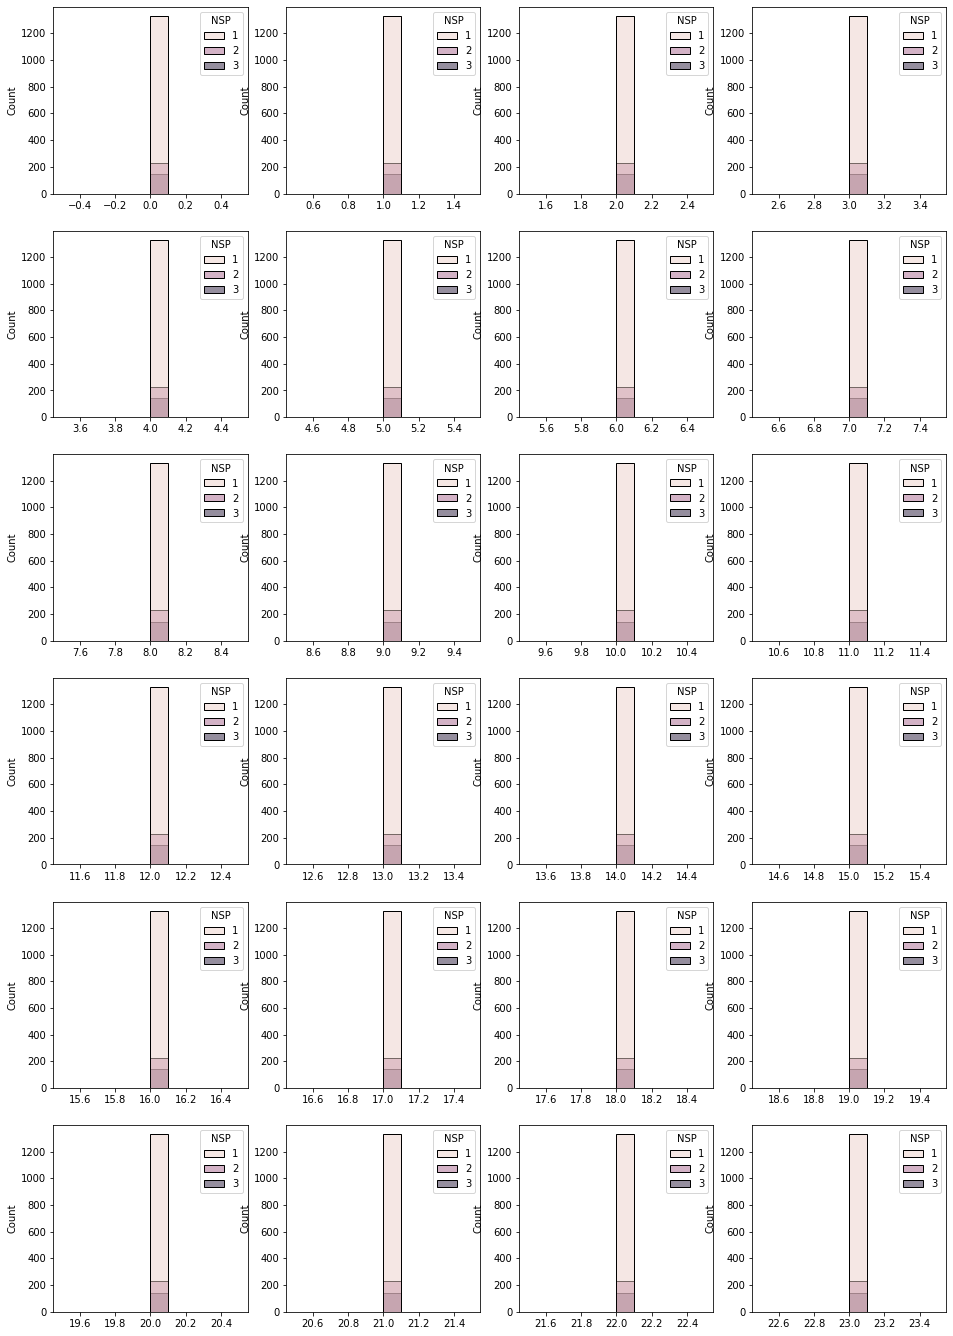

In [10]:
data = ct.fit_transform(train)#.mean()
fig, axes = plt.subplots(ncols=4, nrows=6, figsize=(16, 6*4))

for i, ax in zip(np.arange(len(data)), axes.flatten()):
    sns.histplot(data, x=i, hue=train[ycolumns], ax=ax, bins=10)
    #train[col].hist(bins=10, ax=ax)
    #ax.set_title(col)
    

In [11]:
data.std(0)

array([18.25334916, 18.25334916, 18.00232084,  6.10966886, 12.02991846,
       23.18877491, 12.95423057, 20.25156497, 11.19238718, 17.167381  ,
        5.36112739, 12.11333588,  0.        , 22.15865569, 27.51966995,
       15.56484389, 16.50789132,  7.05438534, 13.01951524, 14.3955175 ,
       13.33689239, 10.98303561, 30.04318659])

In [12]:
#!pip install xgboost

In [13]:

X = train[xcolumns].values
y = train[ycolumns].values-1
X_test = test[xcolumns].values

In [14]:
#!pip install tpot
# from tpot import TPOTClassifier
# tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)#max_time_mins=2)
# tpot.fit(X, y)
# print(tpot.score(X, y))


In [15]:
#tpot.export('tpot_digits_pipeline.py')

In [16]:
from sklearn.preprocessing import QuantileTransformer
rng = np.random.RandomState(0)

transformer=QuantileTransformer(n_quantiles=400, output_distribution='normal')
X_t = transformer.fit_transform(X)
X_test_t = transformer.transform(X_test)

In [17]:
STATE=129
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=7, random_state=STATE, shuffle=True)
from xgboost import XGBClassifier
preds = []
cv_preds = []
for train_index, test_index in skf.split(X, y):
    exported_pipeline = XGBClassifier(learning_rate=0.1, max_depth=7,
                                      min_child_weight=8, n_estimators=100, nthread=1, subsample=0.8,
                                     random_state=STATE)
    # Fix random state in exported estimator
    if hasattr(exported_pipeline, 'random_state'):
        setattr(exported_pipeline, 'random_state', STATE)

    xtrain = X[train_index]
    ytrain = y[train_index]
    xval = X[test_index]
    yval = y[test_index]
    #clf = TabNetClassifier(seed=13) 
    #clf.fit(
    #    xtrain, ytrain, eval_set=[(xval, yval)], weights=1,
    #    eval_metric=[F1, Gini]
    #)
    #cv_preds.append(clf.predict_proba(X_t))
    #preds.append(clf.predict_proba(X_test_t))
    exported_pipeline.fit(xtrain, ytrain, eval_set=[(xval, yval)])#, eval_metric=Gini())
    cv_preds.append(exported_pipeline.predict_proba(X))
    preds.append(exported_pipeline.predict_proba(X_test))

[0]	validation_0-merror:0.09465
[1]	validation_0-merror:0.08231
[2]	validation_0-merror:0.07819
[3]	validation_0-merror:0.07819
[4]	validation_0-merror:0.07819
[5]	validation_0-merror:0.07407
[6]	validation_0-merror:0.07407
[7]	validation_0-merror:0.07407
[8]	validation_0-merror:0.07819
[9]	validation_0-merror:0.07819
[10]	validation_0-merror:0.06996
[11]	validation_0-merror:0.06996
[12]	validation_0-merror:0.06996
[13]	validation_0-merror:0.06996
[14]	validation_0-merror:0.06173
[15]	validation_0-merror:0.06173
[16]	validation_0-merror:0.06584
[17]	validation_0-merror:0.06584
[18]	validation_0-merror:0.06584
[19]	validation_0-merror:0.06584
[20]	validation_0-merror:0.06584
[21]	validation_0-merror:0.06173
[22]	validation_0-merror:0.06173
[23]	validation_0-merror:0.06173
[24]	validation_0-merror:0.06173
[25]	validation_0-merror:0.06173
[26]	validation_0-merror:0.06173
[27]	validation_0-merror:0.06173
[28]	validation_0-merror:0.06173
[29]	validation_0-merror:0.06173
[30]	validation_0-me

[50]	validation_0-merror:0.03292
[51]	validation_0-merror:0.03292
[52]	validation_0-merror:0.03292
[53]	validation_0-merror:0.03292
[54]	validation_0-merror:0.03292
[55]	validation_0-merror:0.03292
[56]	validation_0-merror:0.03292
[57]	validation_0-merror:0.03292
[58]	validation_0-merror:0.02881
[59]	validation_0-merror:0.02881
[60]	validation_0-merror:0.02881
[61]	validation_0-merror:0.02881
[62]	validation_0-merror:0.02881
[63]	validation_0-merror:0.02881
[64]	validation_0-merror:0.02881
[65]	validation_0-merror:0.03292
[66]	validation_0-merror:0.03292
[67]	validation_0-merror:0.03704
[68]	validation_0-merror:0.02881
[69]	validation_0-merror:0.02881
[70]	validation_0-merror:0.03292
[71]	validation_0-merror:0.02881
[72]	validation_0-merror:0.02881
[73]	validation_0-merror:0.02881
[74]	validation_0-merror:0.03292
[75]	validation_0-merror:0.03292
[76]	validation_0-merror:0.02881
[77]	validation_0-merror:0.03292
[78]	validation_0-merror:0.03292
[79]	validation_0-merror:0.03292
[80]	valid

[99]	validation_0-merror:0.03704
[0]	validation_0-merror:0.08231
[1]	validation_0-merror:0.07407
[2]	validation_0-merror:0.07407
[3]	validation_0-merror:0.07407
[4]	validation_0-merror:0.07407
[5]	validation_0-merror:0.07407
[6]	validation_0-merror:0.07407
[7]	validation_0-merror:0.07407
[8]	validation_0-merror:0.07407
[9]	validation_0-merror:0.07407
[10]	validation_0-merror:0.07407
[11]	validation_0-merror:0.07407
[12]	validation_0-merror:0.06996
[13]	validation_0-merror:0.06996
[14]	validation_0-merror:0.06996
[15]	validation_0-merror:0.06996
[16]	validation_0-merror:0.07407
[17]	validation_0-merror:0.07407
[18]	validation_0-merror:0.07407
[19]	validation_0-merror:0.07407
[20]	validation_0-merror:0.07407
[21]	validation_0-merror:0.06996
[22]	validation_0-merror:0.06584
[23]	validation_0-merror:0.06584
[24]	validation_0-merror:0.06584
[25]	validation_0-merror:0.06584
[26]	validation_0-merror:0.06173
[27]	validation_0-merror:0.06173
[28]	validation_0-merror:0.05761
[29]	validation_0-me

In [18]:
#!pip install --upgrade pytorch_tabnet
np.mean(np.stack(cv_preds).mean(0).argmax(1)+1==y+1)

0.9864705882352941

In [19]:
sample_submission['NSP'] = np.stack(preds).mean(0).argmax(1)+1

In [20]:
sample_submission.to_csv("prediction_tabnet_2_2.csv", index=None)

In [27]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X_t)

In [28]:
distances, indices = nbrs.kneighbors(X_test_t)

In [44]:
ids = indices[:, 0]
np.mean(np.stack(cv_preds).mean(0).argmax(1)[ids]+1==y[ids]+1)

0.9929577464788732

In [45]:
ids = indices[:, 1]
np.mean(np.stack(cv_preds).mean(0).argmax(1)[ids]+1==y[ids]+1)

0.9929577464788732